# **Exercise 1: MD simulations of LJ-Ag**

## *SVOLGIMENTO PUNTO 3*

---

## Consegna

### Parametri

In all simulations model Ag interatomic interactions using the LJ potential ($\varepsilon = 0.345$ eV and $\sigma = 2.644$ Å) with the cutoff radius at $R_C = 4.5$ Å. Assume $t_\text{th} = 3$ ps as thermalization time and use the simulation cell of 256-atoms (file `fcc100a256.txt` on the elearning page) unless stated differently. From point 3,

### Punto 1 ✅

Use a **sharp-cutoff** (no polynomial junction) approach and find the optimal timestep to perform a simulation from an initial temperature $T_\text{ini} = 50$ K. The optimal timestep is the maximum one such that $\frac{\delta E}{E} < 10^{−5}$. Consider the range 1, 25 fs and perform 5000 integration steps for each trial. Repeat the analysis for $T_\text{ini} = 500$ K and show that the criterion cannot be fulfilled however reducing the timestep.

#### Dall'analisi

Risulta un $dt$ ottimale di 20 fs per T=50

### Punto 2 ✅

Implement a **7-degree polynomial** junction for $R_P < r < R_C$ with $R_P = 4.2$ Å. Use the coefficients $A, B, \dots, H$ for the 0th, 1st, ..., 7th degree term respectively, as provided in the file `poly7.py` on the elearning page. Adapt the definition of forces accordingly. Check that for $T_\text{ini} = 50$ K the simulation is consistent with the sharp-cutoff one and find the optimal timestep for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K.

#### Dall'analisi

La simulazione con giunzione polinomiale a T=50 è consistente a quella con shar-cutoff. La cosa interessante è che a 500K, usando la giunzione polinomiale, si riesce a scendere sotto il valore di tolleranza di $\frac{\delta E}{E} < 10^{−5}$

Risultano $dt$ ottimali di 20, 6, 4, 3 fs rispettivamente per T = 50, 500, 1000, 5000

### Punto 3 🛠️

For the following points, implement a steepest-descent procedure to start the simulation from a minimum energy configuration (use C= 0.005 Å/𝑒𝑉 and stop when the maximum force falls below 0.001 𝑒𝑉/Å).


Using the optimal timesteps found in point 2, perform 10 𝑝𝑠 long simulations for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K. Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result. Visualize the atomic trajectories of the atoms at the center of the
cluster and at the cube vertices for both the lowest and highest temperature and comment on
their difference.

### Punto 4 🔜

Consider an infinite crystal slab (𝐿𝑥 = 𝐿𝑦 = 16.6416 Å) with free-surfaces in the 𝑧 direction. Add one adatom at the center of the upper surface, with 𝑧 coordinate set 2.4 Å above the maximum 𝑧 coordinate of the atoms in the cell. Perform a 300 𝑝𝑠 long simulation starting from the minimized configuration. Set 𝑇𝑖𝑛𝑖 such to achieve an equilibrium temperature 𝑇 = 850 ± 30 𝐾 and use an appropriate timestep. Trace the trajectory of the adatom over time.

### Punto 5 🔜

Repeat the analysis of point 4 using a (111)-oriented cell from the file fcc111a336+1.txt on the elearning page with 𝐿𝑥 = 𝐿𝑦 = 20.3817 Å and compare the results for the two orientations. Is the adatom diffusion likely to happen at room temperature on one or both surfaces on the same time interval?

---

## Svolgimento PUNTO 3

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MolecularDynamics import CrystalStructure as Crystal
from CMS.MolecularDynamics import CrystalDynamics as Dynamics

In [2]:
# Nome del file (numero di atomi da studiare: 256)
filename = '../../../data/pos-fcc100-random/fcc100a256.txt'

#### Dati globali

In [3]:
# temperature da studiare
temperature = [500, 1000, 2000]

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# ogni temperatura ha un time step ottimale differente
time_step = {
    50: 20e-15,
    500: 6e-15,
    1000: 4e-15,
    2000: 3e-15
}

# il numero di step è dato dal tempo totale (20ps) diviso il time step
tempo_totale = 20e-12
n_steps = {
    50: int(tempo_totale / time_step[50]),
    500: int(tempo_totale / time_step[500]),
    1000: int(tempo_totale / time_step[1000]),
    2000: int(tempo_totale / time_step[2000])
}

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

# raggi di cutoff e giunzione polinomiale
R_C = 4.5
R_P = 4.2

### 1) Configurazione a energia minima con steepest-descend

In [4]:
from CMS.MolecularDynamics.SteepestDescend import SteepestDescend
# per mantenere il codice senza rieseguirlo inutilmente 
# non serve tanto impiega 0.6 secondi
già_fatto_steepest = False

In [5]:
# come nella richiesta
C_steep = 0.005
F_tol = 0.001
max_steps = 20000

In [6]:
# Inizializza la struttura cristallina dal file
if not già_fatto_steepest:
    cristallo_iniziale = Crystal.from_file(filename)
    cristallo_iniziale.set_R_C(R_C)
    cristallo_iniziale.set_R_P(R_P)
    # Esegue minimizzazione con algroritmo di steepest-descend 
    # (598 step con questi parametri)
    steepest = SteepestDescend(cristallo_iniziale)
    potential_energies, max_forces = steepest.minimize_energy(C_steep=C_steep,
                                                                F_tol=F_tol,
                                                                max_steps=max_steps,
                                                                pol_junction=True)
    # FIXME: salva i risultati su file per non doverli ricalcolare
    # già_fatto_steepest = True 

⚠️ Vicini non calcolati in precedenza. Calcolo con R_C=4.5 e R_P=4.2.
Converged in 598 steps.


### 2) Simulazioni di 10ps a T = 500, 1000, 2000

In [7]:
from CMS.MolecularDynamics.io import XYZwriter

dump_interval = {
    500: 20,
    1000: 40,
    2000: 80,
}

In [8]:
# Raccolgo le energie medie e le dev std
E_tot_means = {}
E_tot_stds = {}

E_tot_list = {}
E_k_list = {}
T_list = {}

for T in temperature: # in realtà una sola T iniziale: 50 K
    print(f"\n=== Simulazioni per temperatura iniziale T = {T} K ===")
    print(f"Time step: {time_step[T]*1e15} fs, Numero di step: {n_steps[T]}")
        
    # Ogni volta copio il cristallo iniziale in configurazione minimizzata
    # R_C e R_P sono già settati
    cristallo = cristallo_iniziale.copy()
    
    # PROVO A SETTARE ANCHE UN R_V PER LA VERLET CAGE
    R_V = R_C + 0.5
    # cristallo.set_R_V(R_V) 
    
    # WRITERS
    xyz_writer = XYZwriter(output_folder=f"output/1_3/T={T}K_dt={int(time_step[T]*1e15)}fs/",
                           dt=time_step[T],
                           dump_interval=dump_interval[T])

    simulazione = Dynamics(cristallo,
                           atomic_mass=silver_mass,
                           dt=time_step[T],
                           temp_ini=T,
                           xyz_writer=xyz_writer,)
    simulazione.set_seed(12316543)
    # stavolta output True per visualizzare con ovito
    result = simulazione.run_dynamics(n_steps=n_steps[T],
                                      t_th=t_th
    )
    
    E_tot_means[T] = result.mean_E_tot
    E_tot_stds[T] = result.std_E_tot
    
    E_tot_list[T] = result.energies['total']
    E_k_list[T] = result.energies['kinetic']
    T_list[T] = result.temperatures


=== Simulazioni per temperatura iniziale T = 500 K ===
Time step: 6.0 fs, Numero di step: 3333

=== Simulazioni per temperatura iniziale T = 1000 K ===
Time step: 4.0 fs, Numero di step: 4999

=== Simulazioni per temperatura iniziale T = 2000 K ===
Time step: 3.0 fs, Numero di step: 6666


#### 3) Analisi e plot di $\langle T \rangle$

Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result.

In [9]:
# per comodità salvo le T medie in una lista
T_means = [np.mean(T_list[T]) for T in temperature]

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_82801/2943850083.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Temperatura media $\langle T \\rangle$ (K)')


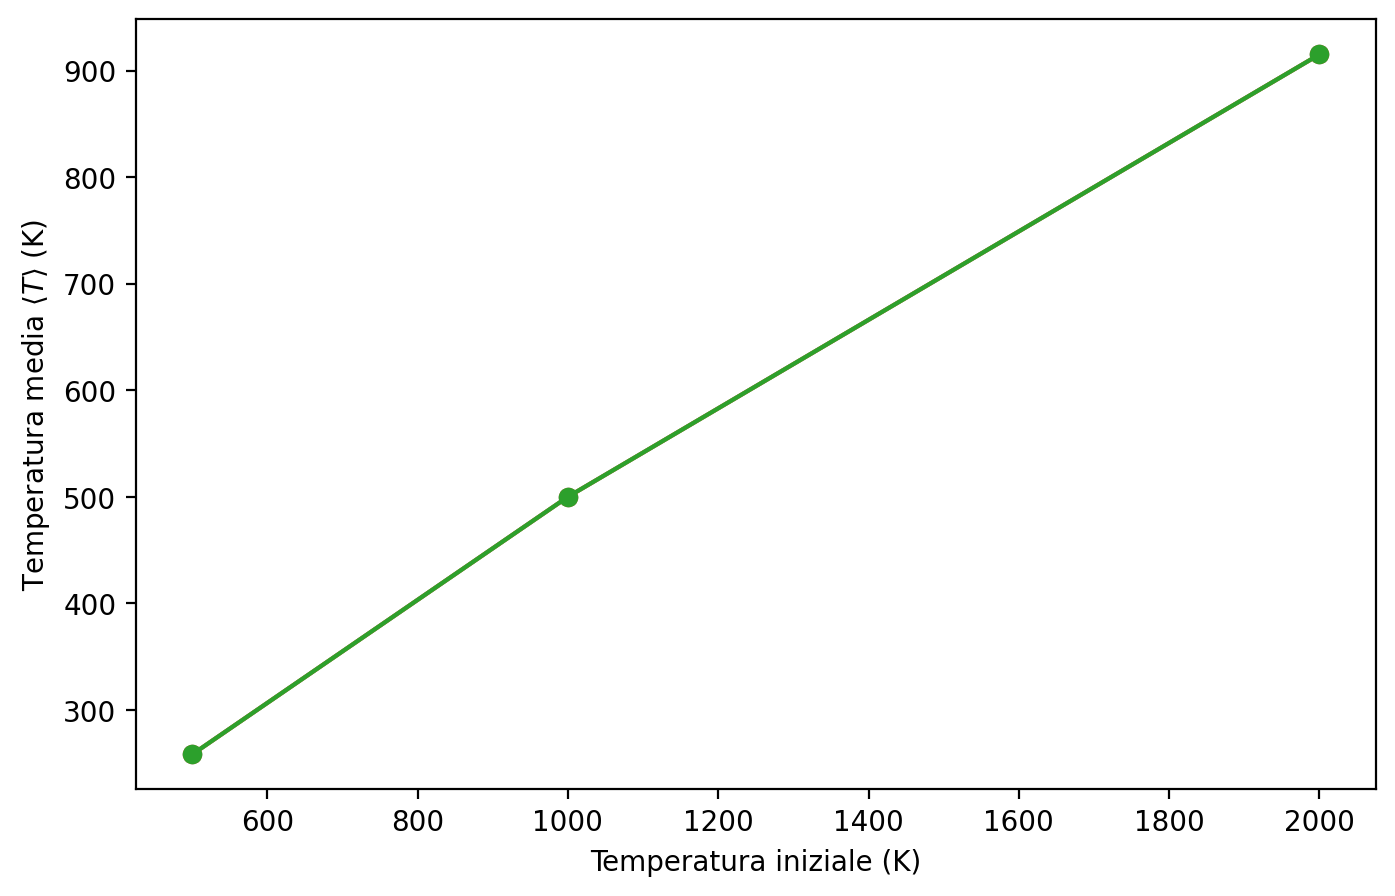

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=200)

for T in temperature:
    
    plt.plot(temperature, T_means, 'o-', label='Temperatura media simulata')
    
plt.xlabel('Temperatura iniziale (K)')
plt.ylabel('Temperatura media $\langle T \\rangle$ (K)')
plt.show()
    

Sembra decisamente che la temperatura media sia la metà di quella iniziale. _Come mai?_